In [255]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from enum import IntEnum
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

# AGENDA for i dag

## data preprocessing
- get features
- rename them
- process them according to workflow.txt

## exploration
- plot thingz:
    - histograms and scatters of relevant things
    - correlation matrix

## transformation into format for modeling
- ??

## modeling
- ??

## evaluation
- visualize results
- conclusion


In [256]:
# READING DATA

attributes_bmi = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "BMICAT_A": "bmi_group",
    "PREGNOW_A": "pregnant",
}

attributes = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "PREGNOW_A": "pregnant",
    "AGEP_A": "age",
    "SEX_A": "gender",
    "EDUCP_A": "education",
    "MARITAL_A": "single",
    "INCWRKO_A": "income",
    "HOUTENURE_A": "owns_home",
    "PARSTAT_A": "parent",
    "DEPFREQ_A": "depression",
    "ANXFREQ_A": "anxiety"
}

df = pd.read_csv("../data/adult23.csv", sep=",")
df = df.loc[:, list(attributes.keys())]
df.rename(mapper=attributes, inplace=True, axis=1)


In [257]:
# removing invalid values
df = df[df["weight"] <= 299]
df = df[df["height"] <= 76]
df = df[df["gender"] <= 2]
df = df[((df["pregnant"] == 2) | (df["gender"] == 1))]
df = df[df["age"] <= 84]
df = df[df["education"] <= 10]
df = df[df["single"] <= 3]
df = df[df["income"] <= 2]
df = df[df["owns_home"] <= 2]
df = df[df["parent"] <= 3]
df = df[df["depression"] <= 5]
df = df[df["anxiety"] <= 5]
for attr in attributes.values():
    print(f"{attr}: {df[attr].unique()}")

weight: [212 160 285 178 140 150 162 130 185 250 253 180 290 187 170 145 220 174
 175 168 141 225 143 270 200 215 146 235 198 230 205 179 210 161 125 240
 195 232 184 155 190 164 245 120 165 122 182 276 114 209 159 110 280 144
 128 127 112 260 102 133 202 204 239 238 192 176 116 189 183 115 177 138
 163 135 181 167 153 117 172 234 265 129 156 100 142 228 237 154 166 254
 171 158 297 173 137 193 148 275 157 206 217 197 261 216 218 267 257 273
 268 196 227 223 132 269 188 136 134 194 243 284 262 231 258 118 126 255
 221 298 105 222 186 191 287 106 256 203 233 295 214 207 226 224 121 107
 219 199 152 149 147 139 211 201 124 263 242 247 208 169 131 103 277 248
 119 213 151 279 272 251 249 123 108 294 113 229 252 288 259 244 111 289
 246 236 274 283 266 264 286 271 292 282 104 241 278 296 299 109 293 281]
height: [71 67 73 69 62 64 66 68 76 72 70 65 63 74 75 60 61 59]
pregnant: [nan  2.]
age: [67 73 48 42 46 36 51 35 56 49 52 79 61 70 21 38 34 23 43 71 25 18 22 31
 72 50 65 20 41 63 24 74 8

In [258]:
# regrouping


"""
EDUCATION
00 (no edu), 01 (no hs), 02 (no diploma): no_hs
03 (ged), 04 (hs), 05 (no deg): highschool
06 (occupational deg), 07 (academic deg), 08 (bsc): bachelor
09 (msc): masters
10 (phd): phd
"""

"""
MARITAL status:
03: single
01 (married) 2 (cohabiting): not
"""

"""
parent
01: parent
02 (in famility but not) 03 (not in family): not
"""

class EduLevel(IntEnum):
    NO_HIGHSCHOOL = 0
    HIGHSCHOOL = 1
    BACHELORS = 2
    MASTERS = 3
    PHD = 4
    

df["education"] = df["education"].replace({
    1: EduLevel.NO_HIGHSCHOOL,
    2: EduLevel.NO_HIGHSCHOOL,
    3: EduLevel.HIGHSCHOOL,
    4: EduLevel.HIGHSCHOOL,
    5: EduLevel.HIGHSCHOOL,
    6: EduLevel.BACHELORS,
    7: EduLevel.BACHELORS,
    8: EduLevel.BACHELORS,
    9: EduLevel.MASTERS,
    10: EduLevel.PHD
})

df["single"] = df["single"].replace({
    1: False,
    2: False,
    3: True
})

df["parent"] = df["parent"].replace({
    1: True,
    2: False,
    3: False
})

/tmp/ipykernel_4127/2400040990.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["single"] = df["single"].replace({
/tmp/ipykernel_4127/2400040990.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["parent"] = df["parent"].replace({


In [259]:
# BMI calculation
POUND_TO_KG = 0.453592
INCH_TO_M = 0.0254
df["weight"] = df["weight"] * POUND_TO_KG
df["height"] = df["height"] * INCH_TO_M
df["bmi"] = df["weight"] / df["height"] ** 2

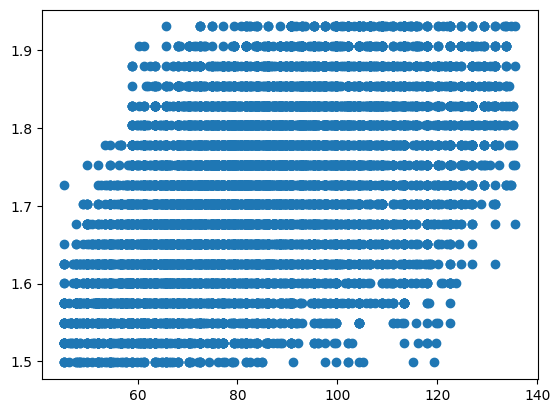

In [260]:
fig, ax = plt.subplots(1)
ax.scatter(df["weight"], df["height"])

In [261]:
del df["weight"]
del df["height"]
del df["pregnant"]

In [262]:
df

,age,gender,education,single,income,owns_home,parent,depression,anxiety,bmi
0,67,1,0,False,2,2,False,1,1,29.567671
1,73,1,2,True,2,1,False,5,5,25.059265
2,48,1,1,False,1,1,True,5,5,37.600801
3,42,2,3,False,1,1,True,5,4,26.285714
5,46,2,2,False,1,1,False,4,2,25.606051
...,...,...,...,...,...,...,...,...,...,...
29513,25,2,2,True,1,2,False,3,2,30.468095
29514,33,2,3,False,1,1,True,4,3,32.690276
29515,44,1,2,False,1,1,True,5,3,25.678196
29516,45,2,3,True,1,1,True,5,2,31.749598


In [271]:
X = pd.DataFrame((df["age"] - df["age"].mean()) / df["age"].std())
#df.drop(["bmi"], axis=1, inplace=False)
y = df["bmi"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X=X_train, y=y_train)
y_pred = model.predict(X_test)


In [272]:
X_test

,age
685,1.495554
10098,-0.247911
7564,-1.584568
17132,0.507590
5015,1.146861
...,...
25173,-0.364142
13415,0.042666
27638,-0.770951
19995,-1.119644


0.00529483107148887

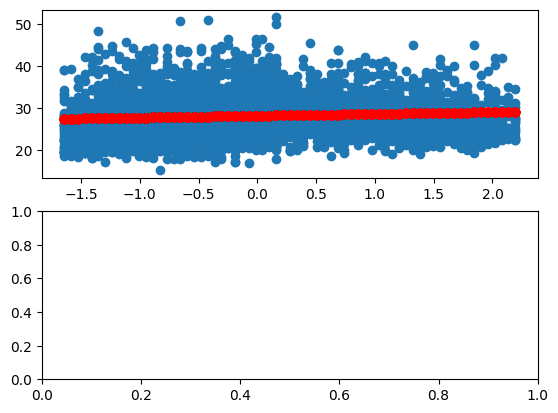

In [274]:


fig, ax = plt.subplots(2)
ax[0].scatter(X_test, y_test)
ax[0].scatter(X_test, y_pred, color="r")


mean_absolute_error( y_true=y_test, y_pred=y_pred)
r2_score(y_true=y_test, y_pred=y_pred)


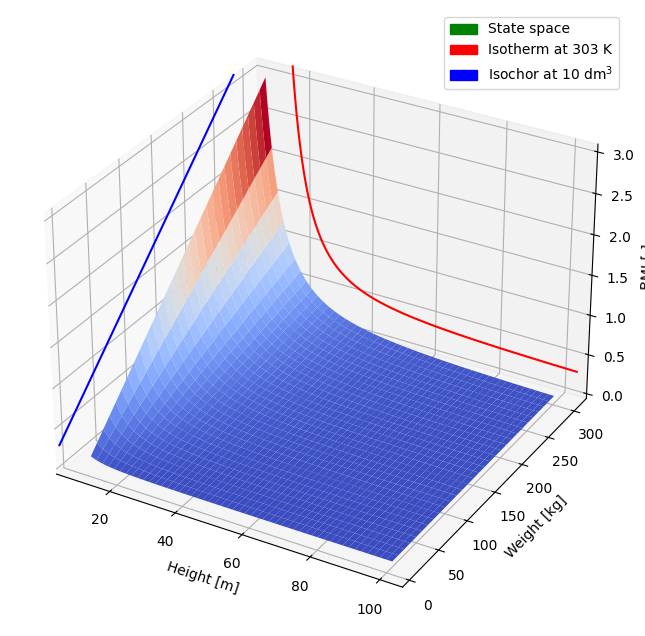

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as ptch

t = np.arange(303, 10, step=-10.1)
v = np.arange(start=10, stop=100, step=0.1)
T, V = np.meshgrid(t,v)
p = T / V**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

surf = ax.plot_surface(V, T, p, label="Állapottér", cmap="coolwarm")

isotherm = ax.contour(V, T, p, zdir='y', offset=350, levels=t[[1]], colors="red")

isochor = ax.contour(V, T, p, zdir='x', offset=0, levels=[v[1]], colors="blue")

ax.set(ylabel="Weight [kg]", xlabel="Height [m]", zlabel="BMI [-]")
 
surf_patch = ptch.Patch(color="green", label="State space")
isotherm_patch = ptch.Patch(color="red", label="Isotherm at 303 K")
isochor_patch = ptch.Patch(color="blue", label="Isochor at 10 dm${^3}$")
ax.legend(handles=(surf_patch, isotherm_patch, isochor_patch))


fig.subplots_adjust(left=0.1, right=0.9)
plt.show()
